In [63]:
from fft_electronic_spin_density.classes import Density
import numpy as np
import matplotlib.pyplot as plt

## Define a real-space function

In [ ]:
xy_lim = 3 # Angstrom
N_real_space = 201

charge_copper = 1.0
charge_ligands = 0.5
sigma_Cu = 0.1
sigma_ligands = 0.2
R_Cu_lig = 1.5
R_Cu_Cu = 0.3 # Angstrom

In [ ]:
def gaussian(x, y, x0, y0, sigma):
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def gaussian_copper_and_ligands(x, y, charge_copper, charge_ligands, sigma_Cu, sigma_ligands, R_Cu_lig, x_displace=0):
    return charge_copper * gaussian(x, y, x_displace, 0, sigma_Cu) + \
              charge_ligands * gaussian(x, y, x_displace, R_Cu_lig, sigma_ligands) + \
                charge_ligands * gaussian(x, y, x_displace, -R_Cu_lig, sigma_ligands)

def plot_density(rho, xy_lim, title='Real-space Electronic Spin Density', cmap='berlin'):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rho, extent=(-xy_lim, xy_lim, -xy_lim, xy_lim), origin='lower', cmap=cmap)
    ax.set_xlabel('x (Angstrom)')
    ax.set_ylabel('y (Angstrom)')
    ax.set_title(title)
    plt.colorbar(ax.imshow(rho, extent=(-xy_lim, xy_lim, -xy_lim, xy_lim), origin='lower', cmap=cmap), ax=ax)
    plt.show()

In [ ]:
x = np.linspace(-xy_lim, xy_lim, N_real_space)
y = np.linspace(-xy_lim, xy_lim, N_real_space)
X, Y = np.meshgrid(x, y)

Z1 = gaussian_copper_and_ligands(X, Y, charge_copper, charge_ligands, sigma_Cu, sigma_ligands, R_Cu_lig, x_displace=R_Cu_Cu/2)
Z2 = gaussian_copper_and_ligands(X, Y, charge_copper, charge_ligands, sigma_Cu, sigma_ligands, R_Cu_lig, x_displace=-R_Cu_Cu/2)

rho_overlap = np.conj(Z1) * Z2
rho_tot = np.abs(Z1) ** 2 - np.abs(Z2) ** 2

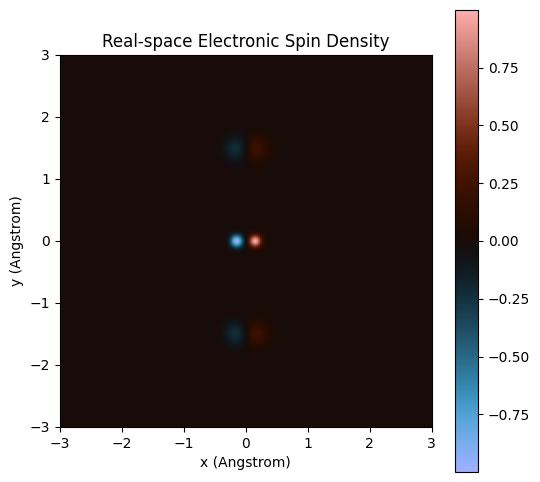

In [67]:
plot_density(rho_tot, xy_lim, title='Real-space Electronic Spin Density', cmap='berlin')

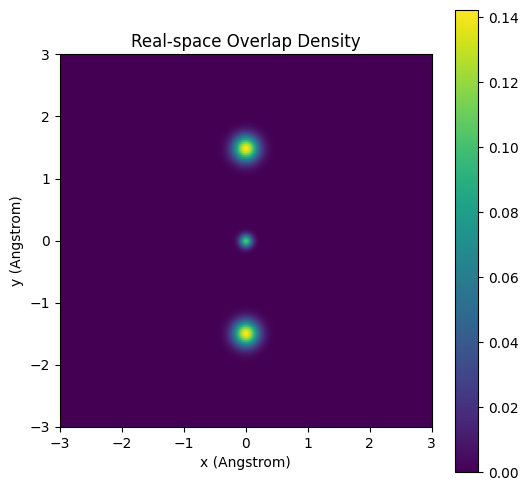

In [68]:
plot_density(rho_overlap, xy_lim, title='Real-space Overlap Density', cmap='viridis')
